# Hands on timeseries analysis
### part5 : Simple time series forecasting models

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.08.09 </div> 
<div style="text-align: right"> Last update: 2020.08.09</div> 

Simple moving average, Weighted moving average, Exponential smoothing 등 간단한 시계열 예측모델을 구성하고 성능을 평가해본다.
- 참고자료  
    - [Pandas로 하는 시계열 데이터분석 5강](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=152#sec2)
    - [Time series analysis in python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

### 1. 시계열 예측모델 평가지표

**1. R squared :** $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```

**2. MAE :** $MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```

**3. MAE(Median Absolute Error) :** $MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```

**4. MSE :** $MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```

**5. MAPE :** $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

- 여기서는 MAE(Mean Absolute Error)를 사용하여 예측결과를 평가해본다.

### 2. 데이터셋 살펴보기

`airline passengers.csv` 데이터셋을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

In [3]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


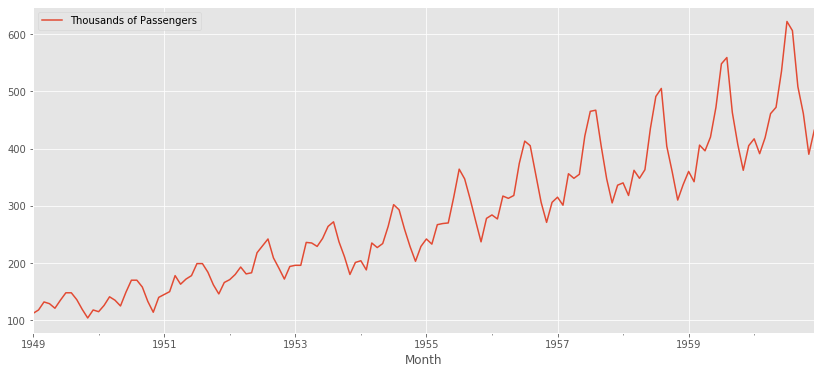

In [4]:
df.plot(figsize = (14, 6))

데이터셋 나누기
- 1960년을 기준으로 학습, 시험 데이터로 구분한다.

In [5]:
train = df[:'1960']
test = df['1960':]

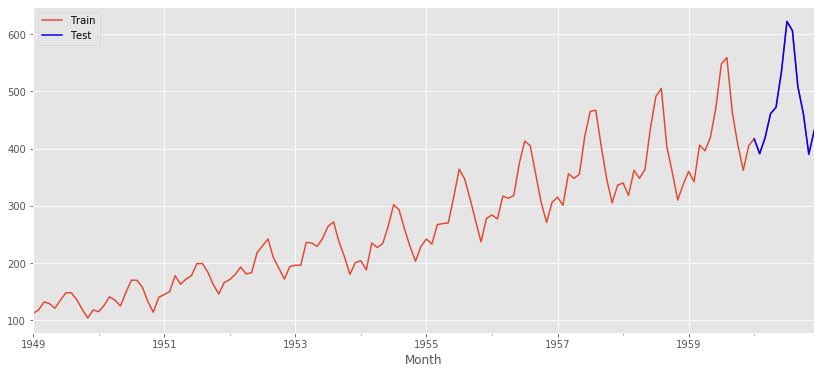

In [6]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
plt.legend()

In [7]:
len(train)

144

In [8]:
len(test)

12

### 3. Forecasting models

#### SMA(Simple Moving Average)

가장 naive한 forecasting 접근법은 이전 값이 현재에도 동일하다고 간주하는 방법이다.  
MA는 이 접근법의 단점을 보완하기 위해 이전 스텝의 값에 평균을 사용한다.

먼저 6개월, 12개월 평균을 계산하여 차트를 그려본다.

In [9]:
df['6M SMA'] = df['Thousands of Passengers'].rolling(window = 6).mean()
df['12M SMA'] = df['Thousands of Passengers'].rolling(window = 12).mean()

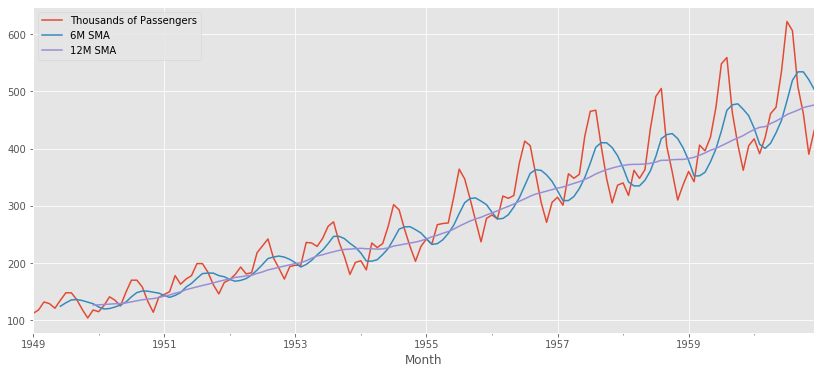

In [10]:
df.plot(figsize = (14, 6))

multistep forecasting model 구현하기

In [11]:
def moving_average(series, window = 6, steps = 1):
    series.values
    results = list()
    for _ in range(0, steps):
        yhat = np.average(series[-window:])
        series = np.append(series, yhat)
        results.append(yhat)
    
    return np.array(results)

In [12]:
results = moving_average(train['Thousands of Passengers'], 6, 12)

In [13]:
results

array([503.16666667, 483.36111111, 462.9212963 , 455.40817901,
       454.47620885, 465.22224366, 470.75928426, 465.35805386,
       462.35754432, 462.26358566, 463.40615344, 464.89447753])

In [14]:
test['Forecasts'] = results

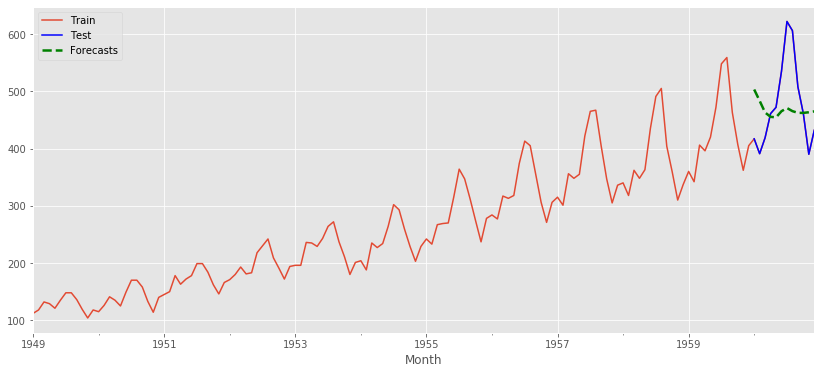

In [15]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
test['Forecasts'].plot(ax = ax, style = 'g--', lw = 2.5, label = 'Forecasts')
plt.legend()

MA의 문제점  
- Seasonality를 잡아내지 못한다.(급변하는 값을 잡아내지 못한다.)  
- window size를 크게 할수록 lag effect가 발생한다.(트렌드를 느리게 반영한다.)

### WMA(Weighted Moving Average)  
- SMA에 문제점을 보완하기 위해 평균을 취할때 샘플마다 가중치를 다르게 한다.  
- 일반적으로 최근 값에 대한 가중치를 크게한다.  
- $\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$  
- 여기서 가중치의 합은 1이다.

In [16]:
weights = np.array([0.4, 0.3, 0.2, 0.1])
sum_weights = np.sum(weights)

In [17]:
df['4M WMA'] = df['Thousands of Passengers'].rolling(window = 4).\
                apply(lambda x: np.sum(weights*x)/sum_weights, raw = False)

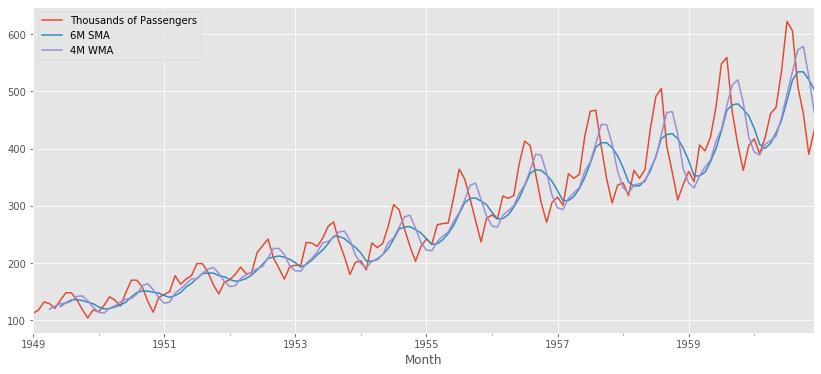

In [18]:
df.drop('12M SMA', axis = 1).plot(figsize = (14, 6))

- WMA가 Seasonality를 더 잘 표현한다.

multistep forecasting model 구현하기

In [19]:
def weighted_average(series, weights, window = 4, steps = 1):
    series.values
    results = list()
    weights.reverse()
    for _ in range(0, steps):
        yhat = 0.0
        for n in range(len(weights)):
            yhat += series[-n-1] * weights[n]
        
        series = np.append(series, yhat)
        results.append(yhat)
    
    return np.array(results)

In [20]:
results = weighted_average(train['Thousands of Passengers'],
                           [0.4, 0.3, 0.2, 0.1], 4, 12)

In [21]:
results

array([462.7       , 434.07      , 421.547     , 440.5787    ,
       443.66827   , 432.574667  , 432.7835307 , 439.12524747,
       437.70893899, 434.4608694 , 435.83886126, 437.43884069])

In [22]:
test['Forecasts'] = results

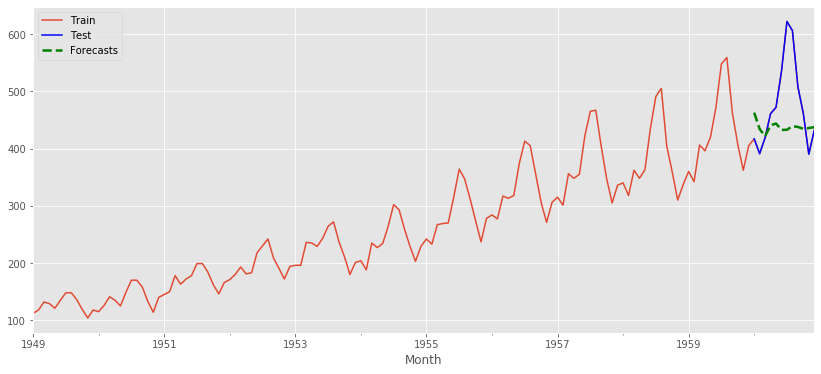

In [23]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
test['Forecasts'].plot(ax = ax, style = 'g--', lw = 2.5, label = 'Forecasts')
plt.legend()

### ES(Exponential Smoothing)  
- 가중치를 exponentialy decaying 하는 값으로 대체한다.  
- $$\hat{y}_{t+1} = \hat y_{t} + \alpha(y_t-\hat y_{t})$$   
- $$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t} $$ 
- 여기서 smoothing factor $\alpha$는 0과 1사이의 값이다.  
- 현시점에서 실제 값 $y_t$를 알 수있으므로 실제 값과 예측 값의 비를 조정하여 예측한다.  
- 위 결과는 1차 ES를 예를 든 것이고 과거 값을 사용하면 고차 ES가 된다.

In [24]:
df['6M EMA'] = df['Thousands of Passengers'].ewm(span = 4).mean()

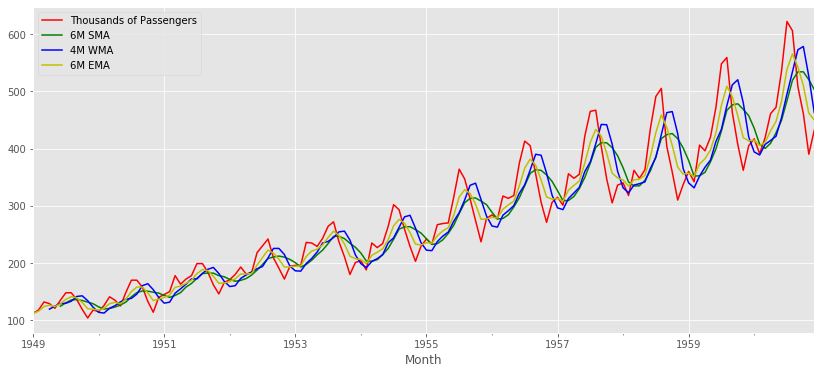

In [25]:
df.drop('12M SMA', axis = 1).plot(figsize = (14, 6), 
                                  color = ['r', 'g', 'b', 'y'])

multistep forecasting model 구현하기

In [26]:
def exponeltial_smoothing(series, alpha, steps = 1): #1차
    series.values
    results = list()
    for _ in range(0, steps):
        yhat = alpha*series[-1] + (1-alpha)*series[-2]
        
        series = np.append(series, yhat)
        results.append(yhat)
    
    return np.array(results)

In [27]:
results = exponeltial_smoothing(train['Thousands of Passengers'],
                           0.3, 12)

In [28]:
results

array([402.6       , 423.18      , 408.774     , 418.8582    ,
       411.79926   , 416.740518  , 413.2816374 , 415.70285382,
       414.00800233, 415.19439837, 414.36392114, 414.9452552 ])

In [29]:
test['Forecasts'] = results

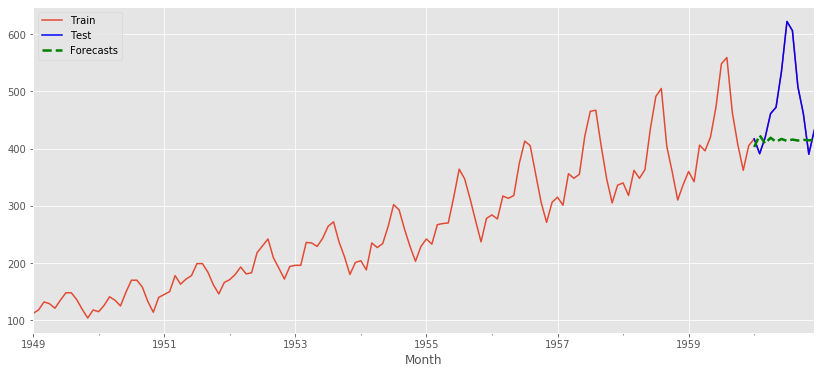

In [30]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
test['Forecasts'].plot(ax = ax, style = 'g--', lw = 2.5, label = 'Forecasts')
plt.legend()

다른방법 : statsmodels 라이브러리를 사용한 모델 구축

In [31]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [32]:
model = SimpleExpSmoothing(train['Thousands of Passengers'].values)
#results = model.fit(smoothing_level=0.3,optimized=False)
results = model.fit()

In [33]:
test['Forecasts'] = results.forecast(len(test))

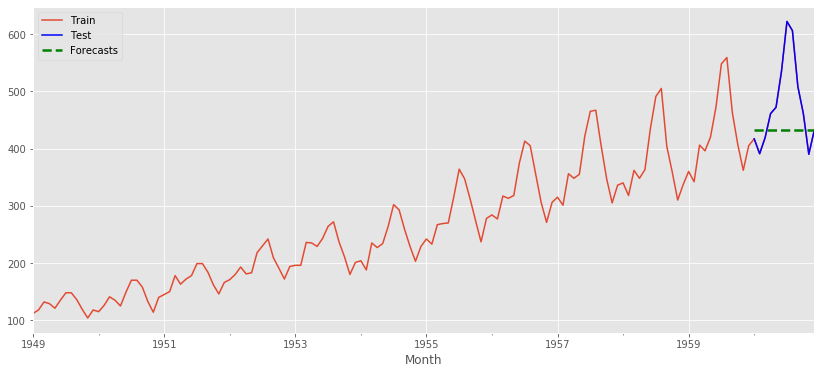

In [34]:
fig, ax = plt.subplots(figsize = (14, 6))
train['Thousands of Passengers'].plot(ax = ax, label = 'Train')
test['Thousands of Passengers'].plot(ax = ax, color = 'b', label = 'Test')
test['Forecasts'].plot(ax = ax, style = 'g--', lw = 2.5, label = 'Forecasts')
plt.legend()

### 4. 정 리  
- moving average에 기반한 시계열 모델을 살펴봤다.  
- moving average 모델은 trend와 seasonality를 반영하지 못하는 단점이 있다.